In [1]:
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.optimizers import Adam, SGD
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
data1 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean5.npz')

In [3]:
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [4]:
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [5]:
del data1, data2, data3, data4, data5

In [6]:
# full_data = np.hstack((ttime, train_data))
# print(full_data)
# print(np.shape(full_data))

ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4  ...  1562  1563  1564  1565  1566  1567
0        2102.67  21   9   26   20   31  ...   -11   -14   -25   -31   -33   -45
1        2102.67  17  20   28   24   29  ...   -10   -19   -26   -25   -30   -41
2        2102.67   8  10   17   13   32  ...   -15   -15   -19   -17   -20   -38
3        2102.67   2   5   14    8   17  ...    10     5   -18   -21   -35   -40
4        2102.67  15  15   10   22   29  ...   -13   -18   -18   -17   -24   -38
...          ...  ..  ..  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...
1324027  3426.95  24  22   18   36   36  ...   250   258   253   233   231   232
1324028  3426.96  24  16   21   32   31  ...   261   246   255   245   232   227
1324029  3426.96  21  30   29   30   25  ...   264   264   246   232   242   238
1324030  3426.96  27  10   20   29   28  ...   265   252   258   248   239   228
1324031  3426.96  58  93  111  124  115  ...   265   248   245   249   224   216

[1324032 rows x 1569 column

In [7]:
# full_df = full_df.groupby(by='Time').mean().reset_index(drop=True).astype('float32').dtypes
# full_df['Time'] = full_df['Time'].shift(-1).fillna(truncate(full_df.iloc[-1,0]+0.01,2))

full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
Time                                         ...                                    
2102.67    18    19     8    24    22    31  ...    -7   -13   -26   -29   -40   -47
2102.68    11    13    13    17    35    33  ...   -12   -18   -24   -25   -35   -38
2102.69    23    30    23    38    37    39  ...    -9   -18   -21   -25   -27   -38
2102.70    18    18    25    22    35    41  ...   -12   -16   -17   -22   -30   -30
2102.71    16    14    22    29    43    46  ...    -7    -5   -15   -28   -14   -36
...       ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
3426.92    24    15    13    25    32    32  ...   249   249   246   244   248   236
3426.93    16    15    27    21    49    32  ...   256   251   237   249   248   235
3426.94    11     1     6    17    23    28  ...   249   246   264   250   243   237
3426.95    24    22    18    36    36    26  ...   250   258   25

In [8]:
full_df2 = full_df.rolling(40, min_periods=1).mean().astype('float32')
print(full_df2)

              0          1          2     ...        1565        1566        1567
Time                                      ...                                    
2102.67  18.000000  19.000000   8.000000  ...  -29.000000  -40.000000  -47.000000
2102.68  14.500000  16.000000  10.500000  ...  -27.000000  -37.500000  -42.500000
2102.69  17.333334  20.666666  14.666667  ...  -26.333334  -34.000000  -41.000000
2102.70  17.500000  20.000000  17.250000  ...  -25.250000  -33.000000  -38.250000
2102.71  17.200001  18.799999  18.200001  ...  -25.799999  -29.200001  -37.799999
...            ...        ...        ...  ...         ...         ...         ...
3426.92  16.350000  19.775000  16.225000  ...  240.600006  235.449997  229.524994
3426.93  15.950000  19.125000  16.325001  ...  241.024994  236.000000  230.100006
3426.94  16.125000  18.799999  16.100000  ...  241.574997  236.574997  230.649994
3426.95  17.525000  20.299999  17.400000  ...  242.074997  237.074997  231.274994
3426.96  18.3250

In [9]:
data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175603:175603+132400].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.90  5.656166
1       2102.91  5.657157
2       2102.92  5.658317
3       2102.93  5.659499
4       2102.94  5.660404
...         ...       ...
132395  3426.85  5.471059
132396  3426.86  5.474545
132397  3426.87  5.478286
132398  3426.88  5.481751
132399  3426.89  5.484813

[132400 rows x 2 columns]


In [10]:
#df = full_df.merge(m_t, on='Time').reset_index(drop=True)
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)


        0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
0         18    11    27    28    32    41  ...    -7    -3    -4   -24   -28   -26
1          3    12    15    20    46    28  ...    -6   -11   -16   -23   -31   -40
2         15    16    13    29    33    39  ...    -6    -9   -15   -15   -25   -42
3          9    18     9    28    44    29  ...   -15   -13   -23   -27   -28   -25
4         22    31    17    24    41    27  ...    -3    -6   -18   -25   -24   -28
...      ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
132370    13     7    13    23    20    18  ...   260   253   248   243   234   232
132371    25    37    15    19    39    30  ...   256   246   251   242   224   227
132372    20    14     7    10    27    18  ...   258   259   245   238   230   231
132373    22     9    17    27    33    29  ...   260   249   235   241   234   219
132374    14    19    17    25    33    36  ...   259   260   252   253   25

In [11]:
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print(X_train.shape, X_val.shape, x_test.shape)
print(Y_train.shape, Y_val.shape, y_test.shape)

(95310, 1568) (10590, 1568) (26475, 1568)
(95310, 1) (10590, 1) (26475, 1)


In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
x_test = scaler.transform(x_test)

X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(95310, 1568, 1) (10590, 1568, 1) (26475, 1568, 1)


In [21]:


inp = Input(shape=(X_train.shape[1:]), name='inp')
conv1 = Conv1D(8, kernel_size=150,  kernel_initializer='random_normal', activation=None)(inp)
pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)
conv2 = Conv1D(16, kernel_size=50, kernel_initializer='random_normal', activation='relu')(pool1)
# pool2 = MaxPooling1D(pool_size=15, strides=1)(conv2)
# conv3 = Conv1D(32, kernel_size=50, kernel_initializer='random_normal', activation='relu')(pool2)
pool3a = MaxPooling1D(pool_size=10, strides=1)(conv2)


conv1 = Conv1D(8, kernel_size=150, kernel_initializer='random_normal', activation='relu')(inp)
pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)
conv2 = Conv1D(16, kernel_size=50, strides=1, kernel_initializer='random_normal', activation='relu')(pool1)
# pool2 = MaxPooling1D(pool_size=15, strides=1)(conv2)
# conv3 = Conv1D(32, kernel_size=50, strides=1, kernel_initializer='random_normal', activation='relu')(pool2)
pool3b = MaxPooling1D(pool_size=10, strides=1)(conv2)

c = Concatenate()([pool3a, pool3b])
# conv1 = Conv1D(16, kernel_size=100, kernel_initializer='random_normal', activation='relu')(c)
# pool1 = MaxPooling1D(pool_size=20, strides=1)(conv1)

f2 = Flatten(name='Features')(c)

m = Dense(128, kernel_initializer = 'random_normal', activation='relu')(f2)
m = Dense(64, kernel_initializer = 'random_normal', activation='relu')(m)
m = Dense(32, kernel_initializer = 'random_normal', activation='relu')(m)
op = Dense(1, kernel_initializer = 'random_normal', activation='relu')(m)
model = Model(inputs=[inp], outputs=[op])

model.compile(loss='mse', optimizer=Adam())

model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_val, Y_val))

print(model.summary())

Epoch 1/15
2979/2979 [==============================] - 24s 8ms/step - loss: 0.3468 - val_loss: 0.0339
Epoch 2/15
2979/2979 [==============================] - 23s 8ms/step - loss: 0.0151 - val_loss: 0.0216
Epoch 3/15
2979/2979 [==============================] - 22s 8ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 4/15
2979/2979 [==============================] - 22s 7ms/step - loss: 0.0071 - val_loss: 0.0121
Epoch 5/15
2979/2979 [==============================] - 22s 8ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 6/15
2979/2979 [==============================] - 22s 8ms/step - loss: 0.0051 - val_loss: 0.0475
Epoch 7/15
2979/2979 [==============================] - 22s 7ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 8/15
2979/2979 [==============================] - 22s 7ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 9/15
2979/2979 [==============================] - 22s 8ms/step - loss: 0.0042 - val_loss: 0.0082
Epoch 10/15
2979/2979 [==============================] - 23s 8ms/step - l

In [22]:
# Evaluate the model
y_predTrain = model.predict(X_train)
y_predTrain = pd.DataFrame(y_predTrain).rolling(20, min_periods=1).mean().astype('float32')
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
y_predVal = pd.DataFrame(y_predVal).rolling(20, min_periods=1).mean().astype('float32')
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  


start_time = time.time()
y_predTest = model.predict(x_test)
y_predTest = pd.DataFrame(y_predTest).rolling(20, min_periods=1).mean().astype('float32')
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))


print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


R^2 scores:  0.827657225966395 0.6638345640756877 0.3886849286167494
RMSE:  0.053361936230606484 0.08482389280254579 0.11322445034185659

---Time for Test data prediction: 1.65951633 seconds ---


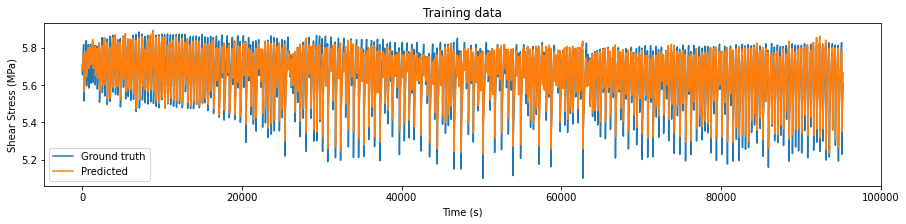

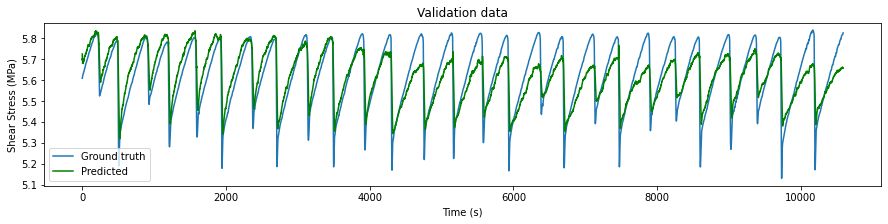

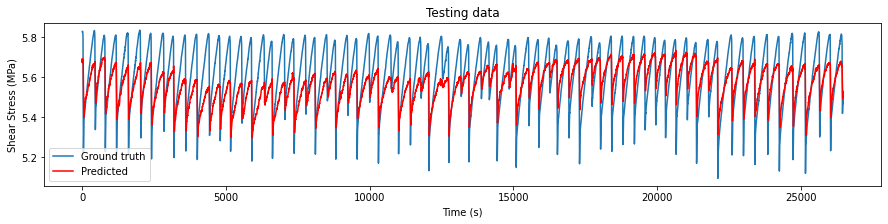

In [23]:
def results_plot(fig_no, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(15,3))
  plt.plot(gt)
  plt.plot(pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data', '')
results_plot(2, Y_val.values, y_predVal, 'Validation data', 'g')
results_plot(3, y_test.values, y_predTest.values, 'Testing data', 'r')